<a href="https://colab.research.google.com/github/benreeves/pydata-calgary/blob/master/Bayesian-Series/Applied-MCMC/predator_prey_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyMC3 ODE & Simulation Demo

---



In [ ]:
!pip install -U pymc3
!pip install arviz

     |████████████████████████████████| 1.9MB 6.0MB/s 
     |████████████████████████████████| 1.5MB 41.2MB/s 
     |████████████████████████████████| 102kB 8.0MB/s 
     |████████████████████████████████| 727kB 39.2MB/s 
     |████████████████████████████████| 4.3MB 45.8MB/s 
     |████████████████████████████████| 296kB 36.2MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=5c8ccd8906524a39593fd0207985e4ec70c5bd1d0951b43497d22cb3c36c4e19
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built contextvars
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [ ]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import numba

In [ ]:
df_lynx_hare = pd.read_csv('https://raw.githubusercontent.com/stan-dev/example-models/master/knitr/lotka-volterra/hudson-bay-lynx-hare.csv', comment='#', index_col='Year', parse_dates=True)

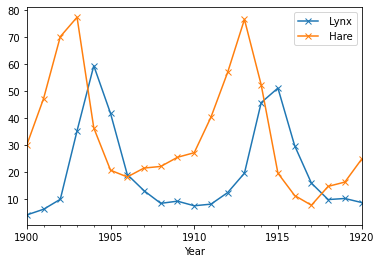

In [ ]:
df_lynx_hare.plot(marker='x')

In [ ]:
df_lynx_hare = df_lynx_hare[[' Hare', ' Lynx']]
df_lynx_hare.columns = ['Hare', 'Lynx']
observed = df_lynx_hare.values
df_lynx_hare.head()

,Hare,Lynx
Year,,
1900-01-01,30.0,4.0
1901-01-01,47.2,6.1
1902-01-01,70.2,9.8
1903-01-01,77.4,35.2
1904-01-01,36.3,59.4


In [ ]:
from scipy.integrate import odeint
X0 = df_lynx_hare.iloc[0]
# size of data
size = len(df_lynx_hare)
# time lapse
time = len(df_lynx_hare)
t = np.linspace(0, time, size)

# Lotka - Volterra equation
def dz_dt(X, t, alpha, beta, gamma, delta):
    """ Return the growth rate of fox and rabbit populations. """
    xi, yi = X[0], X[1]
    dx_dt = alpha * xi - beta*xi*yi
    dy_dt = -gamma*yi + delta*xi*yi
    return np.array([dx_dt, dy_dt])


# simulator function
def competition_model2(alpha, beta, gamma, delta):
    return odeint(dz_dt, y0=X0, t=t, rtol=0.01, args=(alpha, beta, gamma, delta))

In [ ]:
  with pm.Model() as model_lv2:
    alpha =  pm.Normal('alpha', mu=1, sd=0.5)
    beta =  pm.Normal('beta', mu=0.05, sd=0.05)
    gamma =  pm.Normal('gamma', mu=1, sd=0.5)
    delta =  pm.Normal('delta', mu=0.05, sd=0.05)

    sim = pm.Simulator("sim", competition_model2, params=(alpha, beta, gamma, delta),
                       epsilon=10,
                       observed=df_lynx_hare.values)

    trace_lv2 = pm.sample_smc(kernel="ABC", parallel=False)

Initializing SMC sampler...
Multiprocess sampling (2 chains in 1 job)
/usr/local/lib/python3.6/dist-packages/pymc3/smc/sample_smc.py:168: UserWarning: Warning: SMC-ABC is an experimental step method and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
/usr/local/lib/python3.6/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Stage:   0 Beta: 0.003
/usr/local/lib/python3.6/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Stage:   1 Beta: 0.020
Stage:   2 Beta: 0.039
Stage:   3 Beta: 0.063
Stage:   4 Beta: 0.111
Stage:   5 Beta: 0.227
Stage:   6 Beta: 0.467
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.020
Stage:   2 

In [ ]:
with model_lv2:
  idata_lv = az.from_pymc3(trace_lv2)

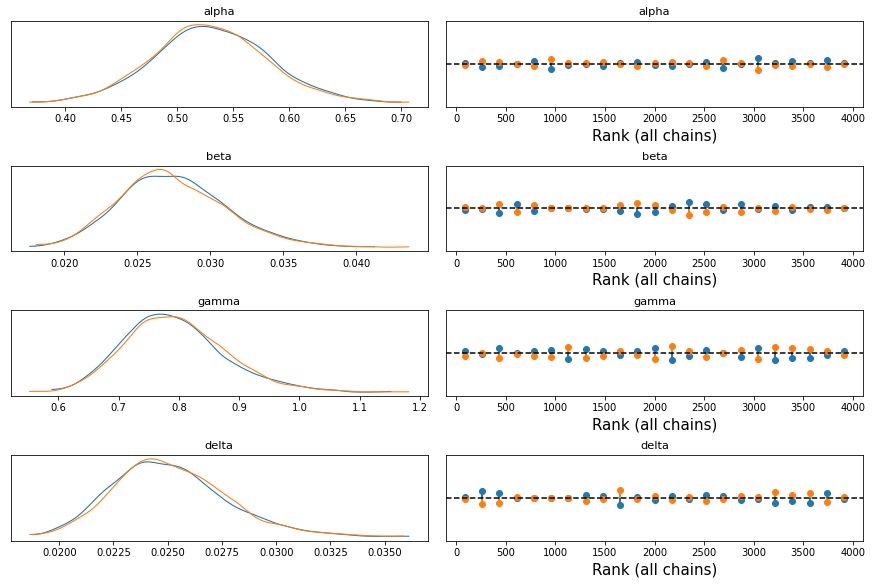

In [ ]:
az.plot_trace(idata_lv, kind="rank_vlines");

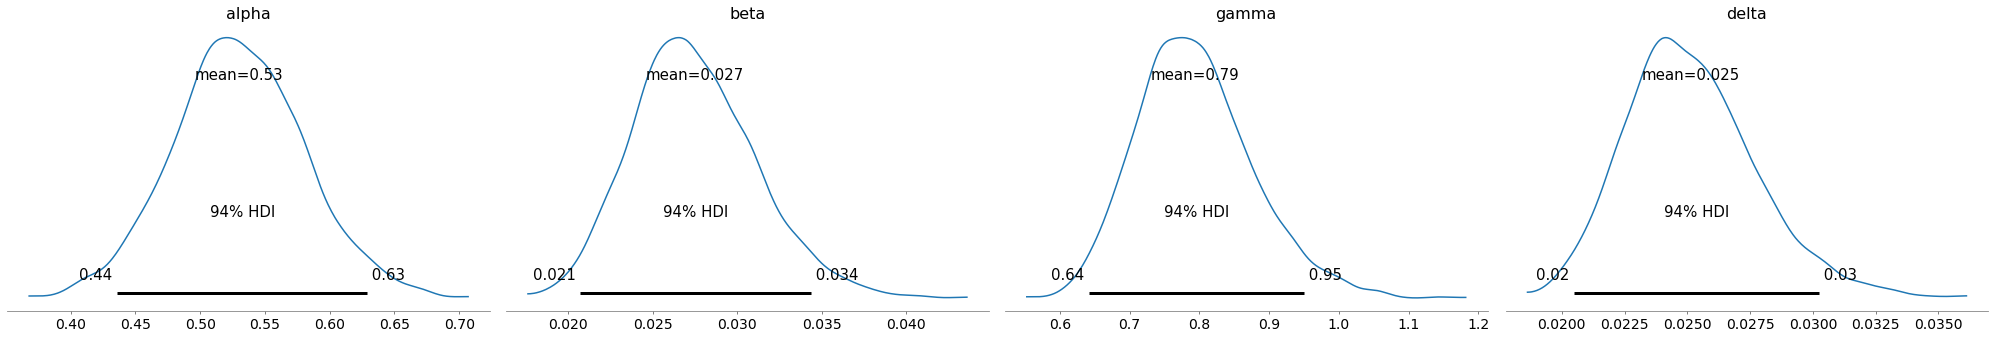

In [ ]:
az.plot_posterior(idata_lv);

In [ ]:
pm.summary(trace_lv2)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.530,0.051,0.436,0.629,0.001,0.001,3946.0,3940.0,3948.0,3921.0,1.0
beta,0.027,0.004,0.021,0.034,0.000,0.000,3814.0,3814.0,3809.0,3770.0,1.0
gamma,0.794,0.083,0.642,0.950,0.001,0.001,4036.0,4036.0,4020.0,3884.0,1.0
delta,0.025,0.003,0.020,0.030,0.000,0.000,3904.0,3881.0,3852.0,3962.0,1.0


Text(0.5, 1.0, 'Predator - Prey Relationship in Lynxes and Hares')

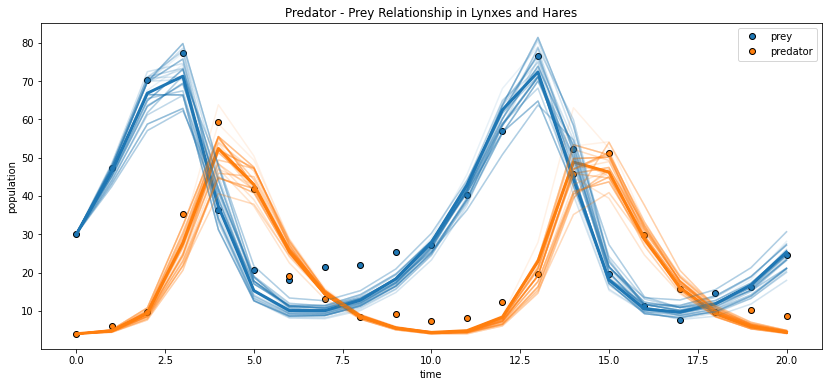

In [ ]:
_, ax = plt.subplots(figsize=(14, 6))
ax.plot(observed[:, 0], "o", label="prey", c="C0", mec='k')
ax.plot(observed[:, 1], "o", label="predator", c="C1", mec='k')
ax.plot(competition_model2(trace_lv2["alpha"].mean(), trace_lv2["beta"].mean(), trace_lv2["gamma"].mean(), trace_lv2["delta"].mean()), linewidth=3)
for i in np.random.randint(0, size, 75):
    sim = competition_model2(trace_lv2["alpha"][i], trace_lv2["beta"][i], trace_lv2["gamma"][i], trace_lv2["delta"][i])
    ax.plot(sim[:,0], alpha=0.1, c="C0")
    ax.plot(sim[:,1], alpha=0.1, c="C1")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.legend();
ax.set_title('Predator - Prey Relationship in Lynxes and Hares')